### Creating an ML model using pyspark to predict if a transaction is credit card fraud or not

In [1]:
# initializing pyspark

import pyspark
from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName("ccfd").setMaster("local")
sc = SparkContext(conf=conf)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/07 19:49:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [3]:
from pyspark.sql.functions import explode
from pyspark.sql.functions import split


In [4]:
# Reading from credit card dataset
data_O = spark.read.load('creditcard.csv', 
                          format='csv', 
                          header='true', 
                          inferSchema='true')
type(data_O)

pyspark.sql.dataframe.DataFrame

In [5]:
# displaying fraud vs non-fraud records
classFreq = data_O.groupBy("Class").count()
classFreq.show()

+-----+------+
|Class| count|
+-----+------+
|    1|   492|
|    0|284315|
+-----+------+



In [6]:
# converting the data to pandas dataframe
# reducing the dataset so no.of records for fraud and non-fraud are equal which helps build a better model 
# as the dataset is highly imbalanced
import pandas as pd
data= data_O.toPandas()
data= data.sample(frac=1)
# amount of fraud classes 492 rows.
fraud_df = data.loc[data['Class'] == 1]
non_fraud_df = data.loc[data['Class'] == 0][:492]

22/10/07 19:49:35 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [7]:
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

In [8]:
# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)
new_df.shape

(984, 31)

Distribution of the Classes in the subsample dataset
0    0.5
1    0.5
Name: Class, dtype: float64


/Users/revanth/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


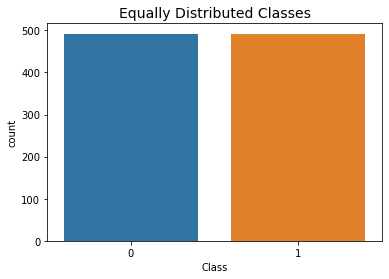

In [9]:
# plotting the new data to see the balance
import seaborn as sns
from matplotlib import pyplot as plt
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))
sns.countplot('Class', data=new_df)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

In [10]:
# Converting back pandas dataframe to spark dataframe

dfff = spark.createDataFrame(new_df)
from pyspark.sql.functions import *
from pyspark.sql.window import Window
win = Window().orderBy('Time')
dfff = dfff.withColumn("idx", row_number().over(win))

In [11]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.linalg import DenseVector

In [12]:
# Dividing the datasets into training and testing sets to train the model

# Dense Vector required in spark to train the data
training_df = dfff.rdd.map(lambda x: (DenseVector(x[0:29]),x[30],x[31]))
training_df = spark.createDataFrame(training_df,["features","label","index"])
training_df = training_df.select("index","features","label")
train_data, test_data = training_df.randomSplit([.8,.2],seed=1234)

22/10/07 19:49:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/07 19:49:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/07 19:49:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


22/10/07 19:49:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/07 19:49:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [13]:
# train set distribution
train_data.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|  394|
|    1|  388|
+-----+-----+



In [14]:
# test set distribution
test_data.groupBy("label").count().show()


+-----+-----+
|label|count|
+-----+-----+
|    0|   98|
|    1|  104|
+-----+-----+



In [15]:
rf = RandomForestClassifier(featuresCol="features", maxDepth=8)
model = rf.fit(train_data)
predictions = model.transform(test_data)
predictions.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|  103|
|       1.0|   99|
+----------+-----+



In [16]:
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)

0.9802786499215074

In [17]:
predictions = predictions.withColumn("fraudPrediction",when((predictions.label==1)&(predictions.prediction==1),1).otherwise(0))
predictions.groupBy("fraudPrediction").count().show()

+---------------+-----+
|fraudPrediction|count|
+---------------+-----+
|              1|   96|
|              0|  106|
+---------------+-----+



In [18]:
predictions.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|   98|
|    1|  104|
+-----+-----+



In [19]:
# Calculating the overall accuracy of the model

from pyspark.sql.functions import col
accurateFraud = predictions.groupBy("fraudPrediction").count().where(predictions.fraudPrediction==1).head()[1]
totalFraud = predictions.groupBy("label").count().where(predictions.label==1).head()[1]
FraudPredictionAccuracy = (accurateFraud/totalFraud)*100
FraudPredictionAccuracy

92.3076923076923

In [20]:
# Extra insights into the predictions

tp = predictions[(predictions.label == 1) & (predictions.prediction == 1)].count()
tn = predictions[(predictions.label == 0) & (predictions.prediction == 0)].count()
fp = predictions[(predictions.label == 0) & (predictions.prediction == 1)].count()
fn = predictions[(predictions.label == 1) & (predictions.prediction == 0)].count()
print("True Positive: ",tp,"\nTrue Negative: ",tn,"\nFalse Positive: ",fp,"\nFalse Negative: ",fn)
print("Recall: ",tp/(tp+fn))
print("Precision: ", tp/(tp+fp))

True Positive:  96 
True Negative:  95 
False Positive:  3 
False Negative:  8
Recall:  0.9230769230769231
Precision:  0.9696969696969697
